In [158]:
%pip install imageio

  Using cached imageio-2.35.1-py3-none-any.whl.metadata (4.9 kB)
Using cached imageio-2.35.1-py3-none-any.whl (315 kB)

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [180]:
# %matplotlib notebook

%matplotlib ipympl

import boost_histogram as bh
import mplhep

import numpy as np

import pandas as pd

import awkward as ak

import h5py
import matplotlib.pyplot as plt

import matplotlib.patches as patches

import imageio

import matplotlib

from ipywidgets import *

from geohelper import geohelper

In [2]:
from sklearn.neighbors import NearestNeighbors

In [3]:
class neighbor_finder:
    """Find out nearest neighbors
    """
    def __init__(self):
        self.points = np.array([])
        self.finder = NearestNeighbors(n_neighbors=1, algorithm='kd_tree')
    def load_points(self, points):
        self.points = points
    def find_k_neighbors(self, points, k):
        if k > 1:
            self.finder = NearestNeighbors(n_neighbors=k, algorithm='kd_tree')
        elif k <=0:
            raise NotImplementedError("k must be non-negative")
        self.finder.fit(self.points)
        distances, indices = self.finder.kneighbors(points)
        return distances, indices

In [4]:
### all Bern module data has been uploaded to NERSC - a NERSC account is not needed to access
### see this link for click-downloadable files: https://portal.nersc.gov/project/dune/data/Module1/TPC12/dataRuns/packetData/
file2306='packet_2022_02_10_22_58_34_CET.h5'
ftimestamp=file2306.split("/")[-1].split('2022_02_10_')[-1].split("_CET")[0]

In [5]:
f=h5py.File(file2306,'r')
io_group_mask=f['packets']['io_group']==1 # selects packets from a specific TPC
packets=f['packets'][io_group_mask]
sync_mask=((packets['packet_type']==6)&(packets['trigger_type']==83)) # selects SYNC packets that are externally generated
print(sync_mask.shape)
sync_idcs=np.argwhere(sync_mask).flatten()
message_groups=np.split(packets, sync_idcs) # partition the packet dataset by sync packet index
print(len(message_groups),' packet groups partitioned by sync packets')

(48479011,)
1201  packet groups partitioned by sync packets


In [48]:
picked_points = np.array([])

def generate_lines(points, lims):
    lims = lims.astype(np.float64)
    points = points.transpose()
    # normalize
    opoints = points.copy()
    points = (points - np.vstack([lims[:,0], lims[:,0]]).transpose()) / (np.vstack([lims[:,1], lims[:,1]]) - np.vstack([lims[:,0], lims[:,0]])).transpose()
    dxyz = np.array([points[i,0] - points[i,1] for i in range(3)])
    output = lims.copy()
    i = np.argmax(np.abs(dxyz))
    if dxyz[i]:
        for j in range(3):
            for k in range(2):
                output[j,k] = points[j,0] + dxyz[j]/dxyz[i] * (k - points[i,0])
    else:
        raise ValueEror
    output = output * (np.vstack([lims[:,1], lims[:,1]]) - np.vstack([lims[:,0], lims[:,0]])).transpose() + np.vstack([lims[:,0], lims[:,0]]).transpose()
    output = output.transpose()
    return output

def interactive_plot_adc(sync_group, counter, threshold):
    """plot ADC sum given (xpos, ypos).
    sync_group: integer, packets within the same SYNC
    counter: integer, the bin to plot, containing larger number of packets than threshold
    threshold: minimum of threshold within a time duration
    """

    
    plt.close('all')

    helper = geohelper()

    mg = message_groups[sync_group]
    data_mask=((mg['packet_type']==0)&(mg['valid_parity']==1)&(mg['timestamp']<1e7)) # filter on data packets with valid parity with sync-consistent timestamp 
    data_packets=mg[data_mask]
    print(len(data_packets),' data packets between syncs')

    # histogram the timestamp packet field
    # roughly 200 microseconds binning assuming ticks up to value 1e7 in datastream between syncs
    counts, xbins = np.histogram(data_packets['timestamp'], bins=500)
    bin_width=xbins[1]-xbins[0]

    physics_bins=[] # save to list bin index for bins exceeding threshold
    for i in range(len(counts)):
        if counts[i]>threshold: physics_bins.append(i)

    print(len(physics_bins),' candidate events')

    if len(physics_bins)==1: return # due to correlated-sync noise, we will always have significant pickup near 0 timestamp


    event_mask = (data_packets['timestamp']>=physics_bins[counter]*bin_width)&(data_packets['timestamp']<physics_bins[counter]*bin_width+bin_width) # filter packets on histgrammed bin of interest
    hits = data_packets[event_mask]
    io_channel = hits['io_channel']
    tile_id = np.array([helper.io_channel_to_tile(ioc) for ioc in io_channel])
    chip_id = hits['chip_id']
    channel_id = hits['channel_id']
    timestamp = hits['timestamp']/1e4 # ms
    dataword = hits['dataword'] # ADC value
    # correlate hardware ID to geometry information to find (x,y) position of hits
    xys = np.fromiter((helper.find_xy(tile, chip, channel) for tile, chip, channel in zip(tile_id, chip_id, channel_id)),
                      dtype=np.dtype((np.float64, 2)))
    x = xys[:,0]
    y = xys[:,1]

    print(len(dataword),' hits in event')

    
    tmin0 = physics_bins[counter]*bin_width / 1E4  #ms
    tmax0 = (physics_bins[counter]*bin_width+bin_width) / 1E4  # ms


    ############
    
    output = widgets.Output()

    figsizeunit = 5
    
    ############
    plt.ioff()
    fig3d = plt.figure('event display & ADC sum', figsize=(2*figsizeunit, figsizeunit))
    ax3d = fig3d.add_subplot(121, projection='3d')
    axslice = fig3d.add_subplot(122)

    figproj = plt.figure('projection of event display', figsize=(2*figsizeunit, 2*figsizeunit))
    axty = figproj.add_subplot(223)
    axxy = figproj.add_subplot(224)
    axtx = figproj.add_subplot(221)
    axproj3d = figproj.add_subplot(222, projection='3d')
    
    fig2 = plt.figure('ADC sum of single channels', figsize=(2*figsizeunit, figsizeunit))
    axadc = fig2.add_subplot(121)
    axadcshift = fig2.add_subplot(122)

    fig3 = plt.figure('ADC sum of single channels, by id', figsize=(2*figsizeunit, figsizeunit))
    axchanneladc = fig3.add_subplot(121)
    axchanneladcshift = fig3.add_subplot(122)

    fig4 = plt.figure('ADC sum within voxels', figsize=(2*figsizeunit, 1*figsizeunit))
    axvoxel = fig4.add_subplot(121)
    axvoxel_x = fig4.add_subplot(122)

    def on_pick_point(event):
        with output if output else nullcontext():
            x, y = event.xdata, event.ydata
            global picked_points
            if len(picked_points) == 0:
                picked_points = np.array([x, y]).reshape(1, 2)
            elif len(picked_points) != 4 and (picked_points.shape != (2, 3)):
                picked_points = np.vstack([picked_points, [x, y]])
            else:
                print("Not adding anymore")
            if len(picked_points) == 4:
                picked_points = np.array(
                    [[picked_points[2,0], picked_points[0,0], picked_points[0,1]], 
                    [picked_points[3,0], picked_points[1,0], picked_points[1,1]]]
                )
                print("Set boundaries", picked_points)
    
    def plot_3d():
        global scat3d
        ax3d.clear()
        scat3d = ax3d.scatter(timestamp, x, y, s=1, picker=True, pickradius=5)
        ax3d.set_xlabel("Timestamp [0.1E4 us]")
        ax3d.set_ylabel("x []", labelpad=10)
        ax3d.set_zlabel("y []")
        plt.tight_layout()
        fig3d.canvas.draw_idle()
        
        # fig3d.canvas.mpl_connect('pick_event', on_pick_point)
        # fig3d.canvas.mpl_connect('button_press_event', on_pick_point)
        fig3d.canvas.flush_events()

    def update_range(updatebutton):
        # plot_adc_slice()
        plot_proj()

    def plot_adc_slice():
        axslice.clear()
        x0, x1 = ax3d.get_xlim()
        y0, y1 = ax3d.get_ylim()
        z0, z1 = ax3d.get_zlim()
        # print("x range:", y0, y1, "[]")
        # print("y range:", z0, z1, "[]")
        # print("t range:", x0, x1, "[]")
        t0 = x0
        t1 = x1

        adcmask = (timestamp > x0) & (timestamp < x1) & (x > y0) & (x < y1) & (y > z0) & (y < z1)

        nbins = 50
        counts, bins = np.histogram(timestamp[adcmask], bins=nbins, range=(t0, t1), weights=dataword[adcmask])
        axslice.stairs(counts, bins)
        
        axslice.set_ylabel("ADC sum per {} [0.1E4 us]".format((t1-t0)/nbins))
        axslice.set_xlabel("Timestamp [0.1E4 us]")
        
        fig3d.canvas.draw_idle()
        fig3d.canvas.flush_events()

    def plot_proj():
        t0, t1 = ax3d.get_xlim()
        x0, x1 = ax3d.get_ylim()
        y0, y1 = ax3d.get_zlim()
        axtx.clear()
        axty.clear()
        axxy.clear()
        axproj3d.clear()

        axtx.set_xlabel('timestamp [1 ms]')
        axtx.set_ylabel('x [mm]')
        axty.set_xlabel('timestamp [1 ms]')
        axty.set_ylabel('y [mm]')
        axxy.set_xlabel('x [mm]')
        axxy.set_ylabel('y [mm]')

        adcmask = (timestamp > t0) & (timestamp < t1) & (x > x0) & (x < x1) & (y > y0) & (y < y1)
        
        # axtx.scatter(timestamp[adcmask], x[adcmask], marker='o', c=dataword[adcmask])
        # axty.scatter(timestamp[adcmask], y[adcmask], marker='o', c=dataword[adcmask])
        # axxy.scatter(x[adcmask], y[adcmask], marker='o', c=dataword[adcmask])
        axtx.scatter(timestamp[adcmask], x[adcmask], s=1, marker='o')
        axty.scatter(timestamp[adcmask], y[adcmask], s=1, marker='o')
        axxy.scatter(x[adcmask], y[adcmask], s=1, marker='o')
        axproj3d.scatter(timestamp[adcmask], x[adcmask], y[adcmask], s=1, marker='o')

        axtx.set_xlim(t0, t1)
        axtx.set_ylim(x0, x1)
        axty.set_xlim(t0, t1)
        axty.set_ylim(y0, y1)
        axxy.set_xlim(x0, x1)
        axxy.set_ylim(y0, y1)
        axproj3d.set_xlim(t0, t1)
        axproj3d.set_ylim(x0, x1)
        axproj3d.set_zlim(y0, y1)

        # global picked_points
        if picked_points.shape == (2, 2):
            axty.hlines(picked_points[:,1], t0, t1, linestyles='dashed',  colors='g')
        if picked_points.shape == (2, 3):
            # zs = np.linspace(picked_points[:,2])
            points = generate_lines(picked_points, np.array([[t0, t1], [x0, x1], [y0, y1]]))
            with output:
                print('plotting', points)
                print('tx', points[:,0], points[:,1])
                print('ty', points[:,0], points[:,2])
                print('xy', points[:,1], points[:,2])
            axtx.plot(points[:,0], points[:,1], color='r')
            axty.plot(points[:,0], points[:,2], color='r')
            axxy.plot(points[:,1], points[:,2], color='r')
            axproj3d.plot(points[:,0], points[:,1], points[:,2], color='r')
        
        figproj.canvas.draw_idle()
        figproj.canvas.mpl_connect('button_press_event', on_pick_point)
        figproj.canvas.flush_events()

 
    k_w = widgets.IntSlider(value=1, min=1, max=10, description='k nearest points', layout={"width": '500px'})
    trange_w = widgets.FloatRangeSlider(value=(tmin0, tmax0), min=tmin0, max=tmax0, description="time stamp min", layout={"width": '500px'})
    points_w = widgets.TagsInput(
        value=[],
        allow_duplicates = False
    )
    def plot_adc(trange, k=1, points=[]):
        axadc.clear()
        axadcshift.clear()

        ### axadcshift
        tlines = None
        nearestchannel = None
        if picked_points.shape == (2, 3):
            t0, t1 = ax3d.get_xlim()
            x0, x1 = ax3d.get_ylim()
            y0, y1 = ax3d.get_zlim()
            boundaries = generate_lines(picked_points, np.array([[t0, t1], [x0, x1], [y0, y1]]))
            npts = 5000
            xylines = np.array([np.linspace(boundaries[0,i], boundaries[1,i], npts) for i in range(1, 3)])
            tlines = np.linspace(boundaries[0,0], boundaries[1,0], npts)
            nearestchannel = neighbor_finder()
            nearestchannel.load_points(xylines.transpose())

        
        ### axadc
        tmin = trange[0]
        tmax = trange[1]

        # adcmask = (timestamp > t0) & (timestamp < t1) & dataword > 0
        
        adcmask = (timestamp > tmin) & (timestamp < tmax) & (dataword > 0)
        xtemp = x[adcmask]
        ytemp = y[adcmask]
        xyvalid = np.stack([xtemp, ytemp]).transpose()
        nearestxy = neighbor_finder()
        
        xyvalid = np.unique(xyvalid, axis=0)
        
        nearestxy.load_points(xyvalid)
    
        nbins = 50
    
        counts = []
        labels = []

        for p in points:
            try:
                (i, j) = p.split(',')
                i = float(i.strip())
                j = float(j.strip())
                # print(i, j)
                distances, indices = nearestxy.find_k_neighbors([[i, j]], k=k)
                for idx in indices[0]:
                    xvalid, yvalid = xyvalid[idx]
                    tileid, chipid, channelid = helper.find_ids(xvalid, yvalid)
                    labels.append("({:.1f},{:.1f})->({:.1f},{:.1f})->{}:{}:{}".format(i, j, xvalid, yvalid, tileid, chipid, channelid))
                    idmask = (tile_id == tileid) & (chip_id == chipid) & (channel_id == channelid)

                    ### axadc
                    
                    # h, bins = np.histogram(timestamp[idmask], bins=nbins, range=(tmin, tmax), weights=dataword[idmask])
                    # counts.append(h)
                    # axadc.stairs(h, bins, label=labels[-1])
                    # adcmask = idmask & (timestamp > tmin) & (timestamp < tmax)
                    # adcmask = idmask
                    # axadc.scatter(timestamp[adcmask], dataword[adcmask], c='r', marker='o')
                    
                    hist = bh.Histogram(bh.axis.Regular(nbins, tmin, tmax))
                    hist.fill(timestamp[idmask], weight=dataword[idmask])
                    h = hist.view()
                    mplhep.histplot(hist, ax=axadc, label=labels[-1])
                    adcmask = idmask & (timestamp > tmin) & (timestamp < tmax)
                    axadc.scatter(timestamp[adcmask], dataword[adcmask], c='r', marker='o')

                    ### axadcshift
                    # with output:
                        # print("tlines1", tlines)
                    if isinstance(tlines, np.ndarray):
                        # with output:
                        distances, indices = nearestchannel.find_k_neighbors([[xvalid, yvalid]], k=1)
                        
                            # print("tlines", tlines)
                        shift = tlines[indices[0][0]]

                        # hshift, binsshift = np.histogram(timestamp[idmask]-shift, bins=nbins, range=(tmin-shift, tmax-shift), weights=dataword[idmask])
                        # axadcshift.stairs(hshift, binsshift, label=labels[-1])
                        histshift = bh.Histogram(bh.axis.Regular(nbins, tmin-shift, tmax-shift))
                        histshift.fill(timestamp[idmask]-shift, weight=dataword[idmask])
                        mplhep.histplot(histshift, ax=axadcshift, label=labels[-1])
                        axadcshift.scatter(timestamp[adcmask]-shift, dataword[adcmask], c='r', marker='o')
                        
            except ValueError:
                continue

        axadc.set_ylabel("ADC sum per {} [0.1E4 us]".format(bin_width/nbins))
        axadc.set_xlabel("Timestamp [0.1E4 us]")
        axadcshift.set_xlabel("Delta t [ms]")
        if labels:
            axadc.legend()
        fig2.canvas.draw_idle()
        fig2.canvas.flush_events()

    channels_w = widgets.TagsInput(
        value=[],
        allow_duplicates = False
    )
    
    def plot_channel_adc(trange, channels=[]):
        axchanneladc.clear()
        axchanneladcshift.clear()

        ### axadcshift
        tlines = None
        nearestchannel = None
        if picked_points.shape == (2, 3):
            t0, t1 = ax3d.get_xlim()
            x0, x1 = ax3d.get_ylim()
            y0, y1 = ax3d.get_zlim()
            boundaries = generate_lines(picked_points, np.array([[t0, t1], [x0, x1], [y0, y1]]))
            npts = 5000
            xylines = np.array([np.linspace(boundaries[0,i], boundaries[1,i], npts) for i in range(1, 3)])
            tlines = np.linspace(boundaries[0,0], boundaries[1,0], npts)
            nearestchannel = neighbor_finder()
            nearestchannel.load_points(xylines.transpose())

        ### axchanneladc
        tmin = trange[0]
        tmax = trange[1]
        
        adcmask = (timestamp > tmin) & (timestamp < tmax) & (dataword > 0)

        nbins = 50
    
        counts = []
        labels = []

        for c in channels:
            tile, chip, channel = [ int(i.strip()) for i in c.split(',')]
            xpos, ypos = helper.find_xy(tile, chip, channel)
            labels.append("({}:{}:{}".format(tile, chip, channel))
            idmask = (tile_id == tile) & (chip_id == chip) & (channel_id == channel)

            ### axchanneladc
            # h, bins = np.histogram(timestamp[idmask], bins=nbins, range=(tmin, tmax), weights=dataword[idmask])
            # counts.append(h)
            # axchanneladc.stairs(h, bins, label=labels[-1])
            hist = bh.Histogram(bh.axis.Regular(nbins, tmin, tmax))
            hist.fill(timestamp[idmask], weight=dataword[idmask])
            h = hist.view()
            # bins = h
            mplhep.histplot(hist, ax=axchanneladc, label=labels[-1])
            # axchanneladc.hist(timestamp[idmask], bins=nbins, range=(tmin, tmax), weights=dataword[idmask], label=labels[-1])
            adcmask = idmask & (timestamp > tmin) & (timestamp < tmax)
                    # adcmask = idmask
            axchanneladc.scatter(timestamp[adcmask], dataword[adcmask], c='r', marker='o')
            labels.append("{}:{}:{}".format(tileid, chipid, channelid))
            '''
            with output:
                print("tmin, tmax", tmin, tmax)
                print("timestamp hist", timestamp[idmask])
                print("adc hist", dataword[adcmask])
                print("timestamp scatter", timestamp[idmask])
                print("adc scatter", dataword[adcmask])
                print("stat", h)
                '''
            if isinstance(tlines, np.ndarray):
                # with output:
                distances, indices = nearestchannel.find_k_neighbors([[xpos, ypos]], k=1)
                        
                shift = tlines[indices[0][0]]

                histshift = bh.Histogram(bh.axis.Regular(nbins, tmin-shift, tmax-shift))
                histshift.fill(timestamp[idmask]-shift, weight=dataword[idmask])
                # hshift, binsshift = np.histogram(timestamp[idmask]-shift, bins=nbins, range=(tmin-shift, tmax-shift), weights=dataword[idmask])
                # axchanneladcshift.stairs(hshift, binsshift, label=labels[-1])
                mplhep.histplot(histshift, ax=axchanneladcshift, label=labels[-1])
                axchanneladcshift.scatter(timestamp[adcmask]-shift, dataword[adcmask], c='r', marker='o')
                
                
        axchanneladc.set_ylabel("ADC sum per {} [0.1E4 us]".format(bin_width/nbins))
        axchanneladc.set_xlabel("Timestamp [0.1E4 us]")
        
        axchanneladcshift.set_xlabel("Delta t [ms]")
        
        if labels:
            axadc.legend()
        fig3.canvas.draw_idle()
        fig3.canvas.flush_events()

    def get_ranges(boundaries, n, dy, dt1, dt2):
        ts = np.linspace(boundaries[0,0], boundaries[1,0], n+1)
        ts = np.diff(ts)/2. + ts[0:-1]
        t0s = ts - dt1
        t1s = ts + dt2

        xs = np.linspace(boundaries[0,1], boundaries[1,1], n+1)
        x0s = xs[0:-1]
        x1s = xs[1:]
    
        ys = np.linspace(boundaries[0,2], boundaries[1,2], n+1)
        ys = (ys[0:-1] + ys[1:])/2.
        # y0s = ys[0:-1]
        # y1s = ys[1:]
        y0s = ys-dy
        y1s = ys+dy

        return np.transpose(np.vstack([t0s, t1s, x0s, x1s, y0s, y1s]))

    nseg_w = widgets.IntText(
        value = 100,
        description = 'n segmentation of xy projection',
        disabled=False
    )

    dy_w = widgets.FloatText(
        value=15,
        description='dy [mm]:',
        disabled=False
    )
        
    dt1_w = widgets.FloatText(
        value=0.02,
        description='dt1 [ms]:',
        disabled=False
    )
    dt2_w = widgets.FloatText(
        value=0.01,
        description='dt2 [ms]:',
        disabled=False
    )
    def plot_adc_int(n, dy, dt1, dt2):
        axvoxel.clear()
        axvoxel_x.clear()
        axvoxel.set_xlabel('step')
        axvoxel.set_ylabel('ADC sum')
        axvoxel_x.set_xlabel('x [mm]')
        axvoxel_x.set_ylabel('ADC sum')
        if picked_points.shape == (2, 3):
            t0, t1 = ax3d.get_xlim()
            x0, x1 = ax3d.get_ylim()
            y0, y1 = ax3d.get_zlim()
            boundaries = generate_lines(picked_points, np.array([[t0, t1], [x0, x1], [y0, y1]]))

            adc_ints = []
            voxels = get_ranges(boundaries, n, dy, dt1, dt2)
            x_x = []
            dw = []
            for ax in [axtx, axty, axxy]:
                for p in ax.patches:
                    if isinstance(p, patches.Rectangle):
                        p.remove()
            for voxel in voxels:
                m = (timestamp > voxel[0]) & (timestamp < voxel[1]) \
                    & (xys[:,0] > voxel[2]) & (xys[:,0] < voxel[3]) \
                    & (xys[:,1] > voxel[4]) & (xys[:,1] < voxel[5]) \
                    & (timestamp > t0) & (timestamp < t1) \
                    & (xys[:,0] > x0) & (xys[:,0] < x1) \
                    & (xys[:,1] > y0) & (xys[:,1] < y1)
                adc_ints.append(np.sum(dataword[m]))
                x_x = np.concat((x_x, xys[:,0][m]))
                dw = np.concat((dw, dataword[m]))
                # rectangular
                for ax, (idx0, idx1) in zip([axtx, axty, axxy], [[0, 2], [0, 4], [2, 4]]):
                    rect = patches.Rectangle((voxel[idx0], voxel[idx1]), voxel[idx0+1]-voxel[idx0], voxel[idx1+1]-voxel[idx1], linewidth=1, edgecolor='g', facecolor='none')
                    ax.add_patch(rect)
            for ax, (idx0, idx1) in zip([axtx, axty, axxy], [[0, 1], [0, 2], [1, 2]]):
                rect = patches.Rectangle((picked_points[0][idx0], picked_points[0][idx1]),
                                         picked_points[1][idx0]-picked_points[0][idx0], picked_points[1][idx1]-picked_points[0][idx1],
                                        linewidth=1, linestyle='dashed', edgecolor='g', facecolor='none')
                ax.add_patch(rect)
            hx = bh.Histogram(bh.axis.Regular(n, x0, x1))
            hx.fill(x_x, weight=dw)
            axvoxel.plot(adc_ints)
            # axvoxel.plot(hx.values())
            axvoxel.text(0.1, np.max(adc_ints),
                         "xy ({:.1f},{:.1f})-->({:.1f},{:.1f})".format(boundaries[0,1], boundaries[0,2], boundaries[1,1], boundaries[1,2]))
            axvoxel.text(0.1, 0.9*np.max(adc_ints),
                         "dx: {:.2f} dy: {:.2f}".format(voxels[0,3]-voxels[0,2], voxels[0,5]-voxels[0,4]))
            axvoxel.text(0.1, 0.8*np.max(adc_ints),
                         "[-{:.2f}, {:.2f}]".format(dt1, dt2))


            mplhep.histplot(hx, ax=axvoxel_x)
            
        figproj.canvas.draw_idle()
        figproj.canvas.flush_events()            

        fig4.canvas.draw_idle()
        fig4.canvas.flush_events()

    plot_3d()
    # plot_adc_slice()
    plot_proj()
    
    button = widgets.Button(description="Update ADC sum in range", layout={"width": '500px'}) 
    button_reset_points = widgets.Button(description="Reset picked points", layout={"width": '500px'})
    def reset_picked_points(updatebutton):
        global picked_points
        picked_points = np.array([])
    button_reset_points.on_click(reset_picked_points)

    # middle_plot = interactive_output(plot_adc_slice, {"updatebutton": button})

    button.on_click(update_range)

    interactive_plot = interactive_output(plot_adc, {"trange" : trange_w, "k" : k_w, "points" : points_w})

    interactive_plot2 = interactive_output(plot_channel_adc, {"trange" : trange_w, "channels" : channels_w})

    interactive_plot4 = interactive_output(plot_adc_int, {"n" : nseg_w, 'dy' : dy_w, "dt1" : dt1_w, "dt2": dt2_w})

    fig3d.show()
    figproj.show()
    display(button_reset_points, button, output)
    display(widgets.VBox([points_w, trange_w, k_w]), interactive_plot)
    fig2.show()
    display(widgets.VBox([channels_w, trange_w]), interactive_plot2)
    fig3.show()
    display(widgets.VBox([nseg_w, dy_w, dt1_w, dt2_w]), interactive_plot4)
    fig4.show()
    

In [7]:
# interactive_plot_adc(2, 4, 500)
# 6, 40, 20

27470  data packets between syncs
14  candidate events
657  hits in event


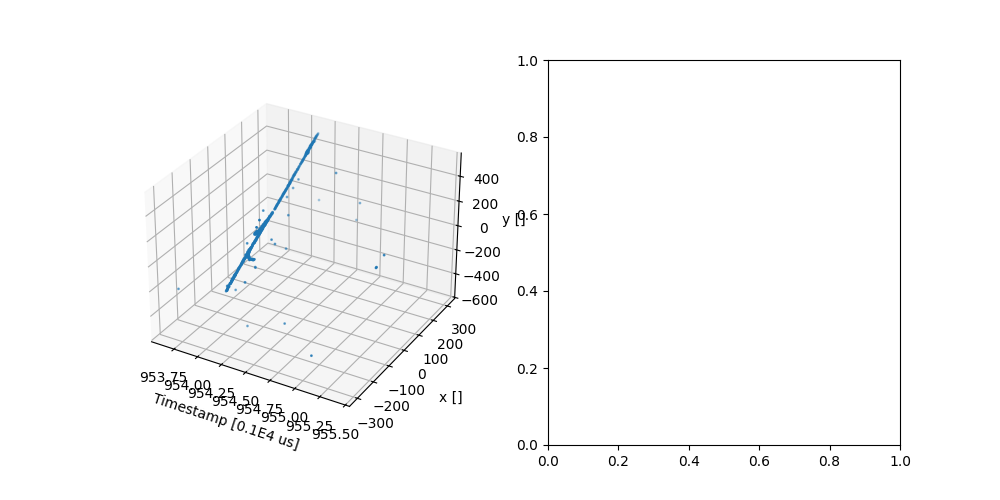

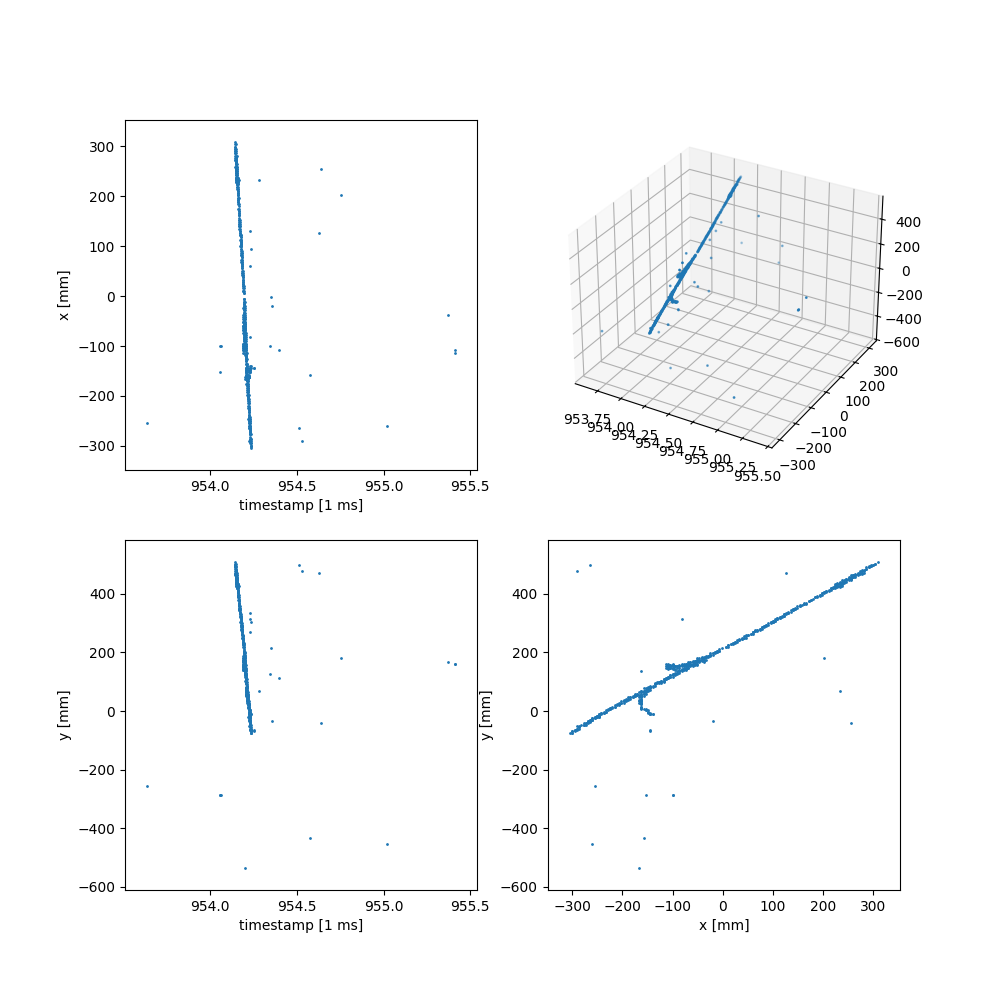

Button(description='Reset picked points', layout=Layout(width='500px'), style=ButtonStyle())

Button(description='Update ADC sum in range', layout=Layout(width='500px'), style=ButtonStyle())

Output()

Output()

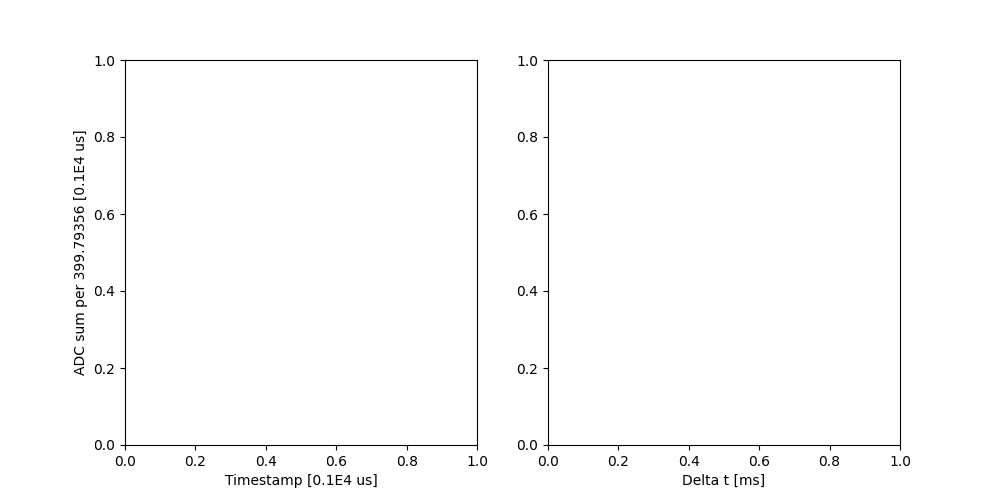

Output()

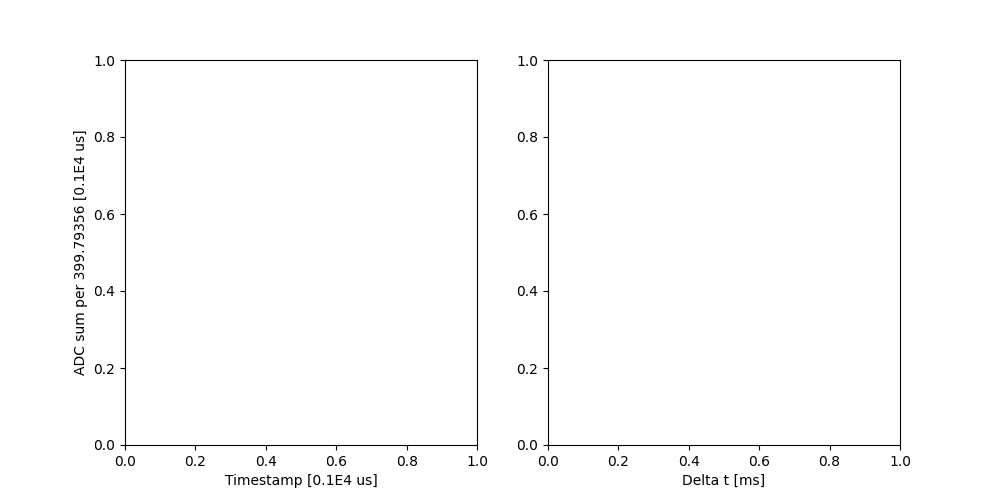

Output()

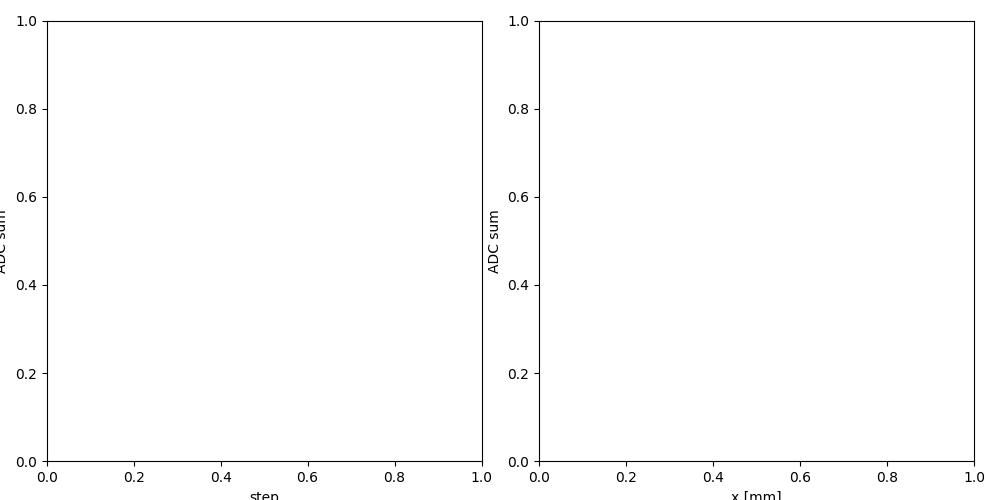

In [49]:
interactive_plot_adc(16, 13, 500)

In [9]:
def check_tile(sync_group, counter, threshold, x0, x1, y0, y1, t0, t1):
    """plot ADC sum given (xpos, ypos).
    sync_group: integer, packets within the same SYNC
    counter: integer, the bin to plot, containing larger number of packets than threshold
    threshold: minimum of threshold within a time duration
    """

    
    plt.close('all')

    helper = geohelper()

    mg = message_groups[sync_group]
    data_mask=((mg['packet_type']==0)&(mg['valid_parity']==1)&(mg['timestamp']<1e7)) # filter on data packets with valid parity with sync-consistent timestamp 
    data_packets=mg[data_mask]
    print(len(data_packets),' data packets between syncs')

    # histogram the timestamp packet field
    # roughly 200 microseconds binning assuming ticks up to value 1e7 in datastream between syncs
    counts, xbins = np.histogram(data_packets['timestamp'], bins=500)
    bin_width=xbins[1]-xbins[0]

    physics_bins=[] # save to list bin index for bins exceeding threshold
    for i in range(len(counts)):
        if counts[i]>threshold: physics_bins.append(i)

    print(len(physics_bins),' candidate events')

    if len(physics_bins)==1: return # due to correlated-sync noise, we will always have significant pickup near 0 timestamp

    event_mask = (data_packets['timestamp']>=physics_bins[counter]*bin_width)&(data_packets['timestamp']<physics_bins[counter]*bin_width+bin_width) # filter packets on histgrammed bin of interest
    hits = data_packets[event_mask]
    io_channel = hits['io_channel']
    tile_id = np.array([helper.io_channel_to_tile(ioc) for ioc in io_channel])
    chip_id = hits['chip_id']
    channel_id = hits['channel_id']
    timestamp = hits['timestamp']/1e4 # ms
    dataword = hits['dataword'] # ADC value
    # correlate hardware ID to geometry information to find (x,y) position of hits
    xys = np.fromiter((helper.find_xy(tile, chip, channel) for tile, chip, channel in zip(tile_id, chip_id, channel_id)),
                      dtype=np.dtype((np.float64, 2)))
    x = xys[:,0]
    y = xys[:,1]

    print(len(dataword),' hits in event')

    
    tmin0 = physics_bins[counter]*bin_width / 1E4  #ms
    tmax0 = (physics_bins[counter]*bin_width+bin_width) / 1E4  # ms

    xyzmask = (x > x0) & (x < x1) & (y > y0) & (y < y1) & (timestamp > t0) & (timestamp < t1)

    df = pd.DataFrame(tile_id[xyzmask], columns=['tile_id'])
    print(df.value_counts())
    


In [10]:
check_tile(121, 6, 500, -300, 300, -600, 600, 701, 703)

55253  data packets between syncs
8  candidate events
14651  hits in event
tile_id
2          8079
1          2737
8           820
4           709
3           659
5           430
6           270
7            22
Name: count, dtype: int64


In [11]:
check_tile(121, 6, 500, -300, 300, 150, 600, 701, 703)

55253  data packets between syncs
8  candidate events
14651  hits in event
tile_id
2          8079
1          2737
4           666
3           447
Name: count, dtype: int64


50409  data packets between syncs
9  candidate events
9630  hits in event


Button(description='Reset picked points', layout=Layout(width='500px'), style=ButtonStyle())

Button(description='Update ADC sum in range', layout=Layout(width='500px'), style=ButtonStyle())

Output()

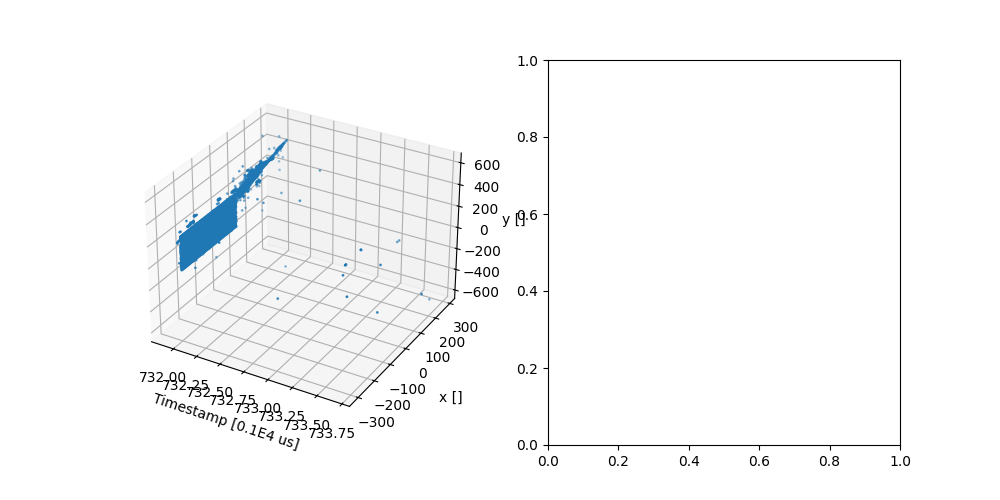

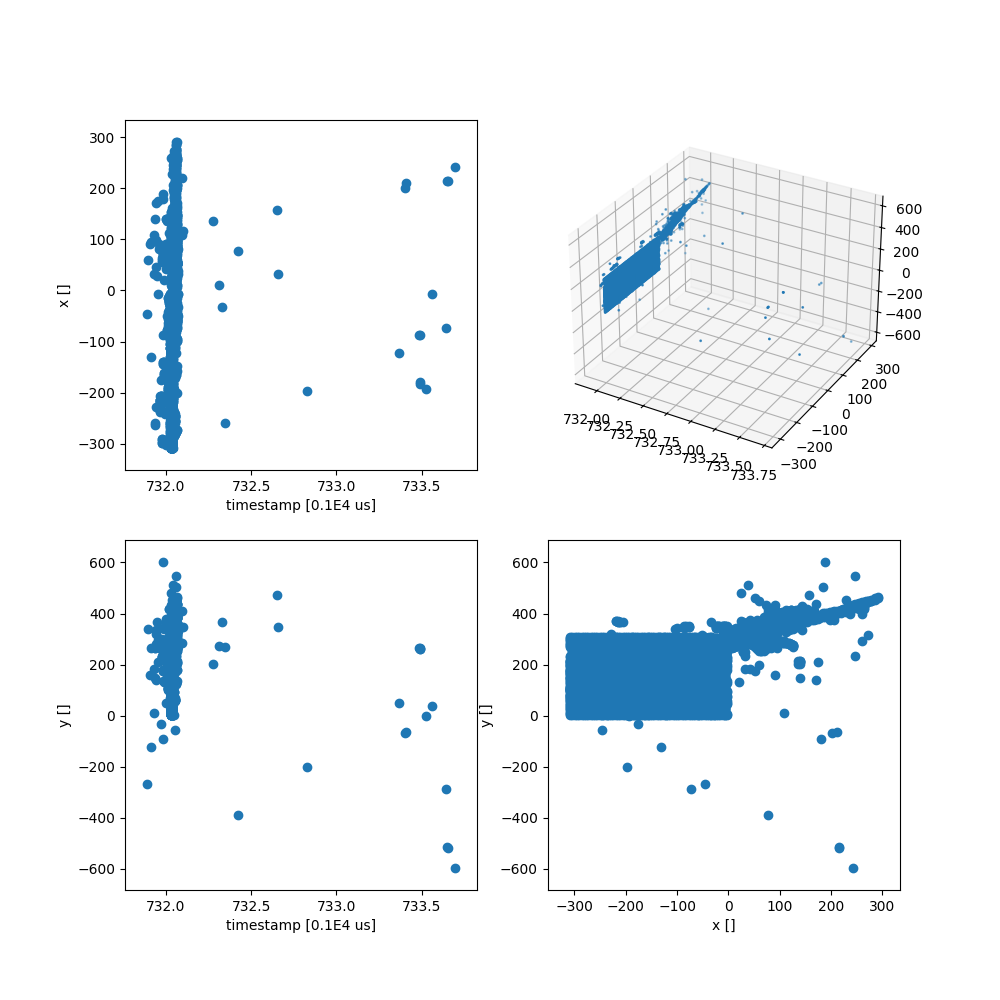

Output()

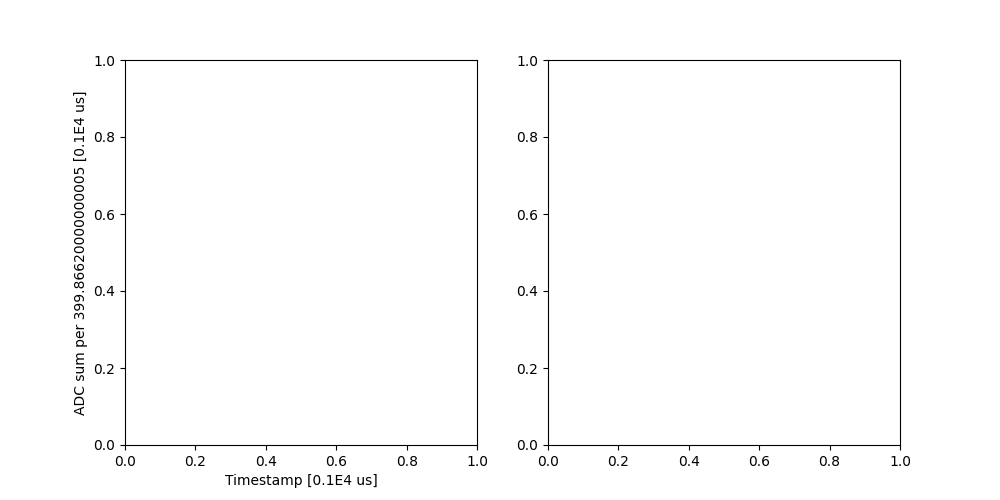

Output()

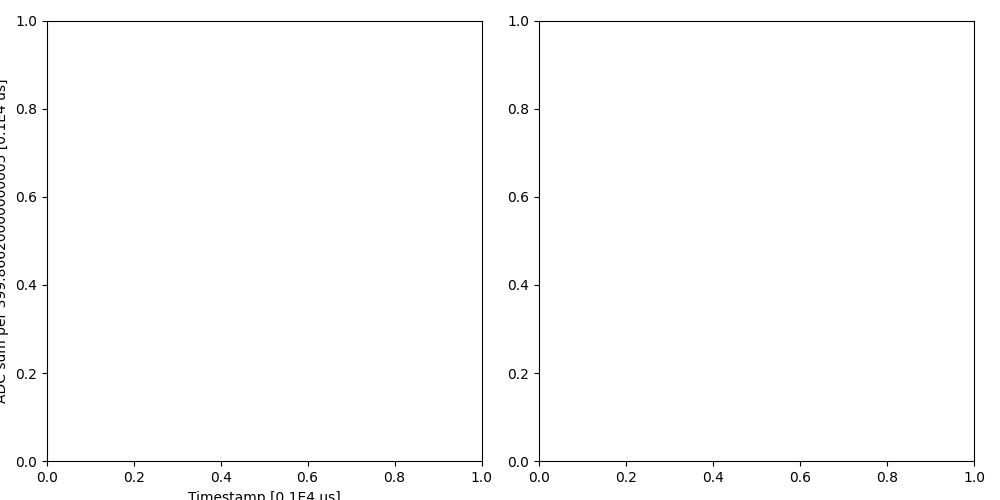

In [12]:
interactive_plot_adc(11, 6, 500)

In [13]:
check_tile(11, 6, 500, -300, 0, 0, 150, 731, 733)

50409  data packets between syncs
9  candidate events
9630  hits in event
tile_id
3          3800
Name: count, dtype: int64


27352  data packets between syncs
12  candidate events
1724  hits in event


Button(description='Reset picked points', layout=Layout(width='500px'), style=ButtonStyle())

Button(description='Update ADC sum in range', layout=Layout(width='500px'), style=ButtonStyle())

Output()

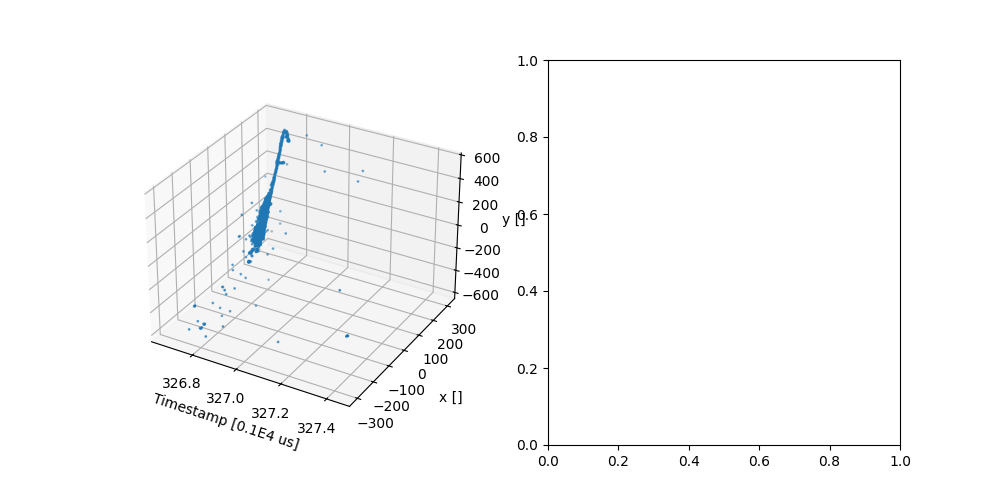

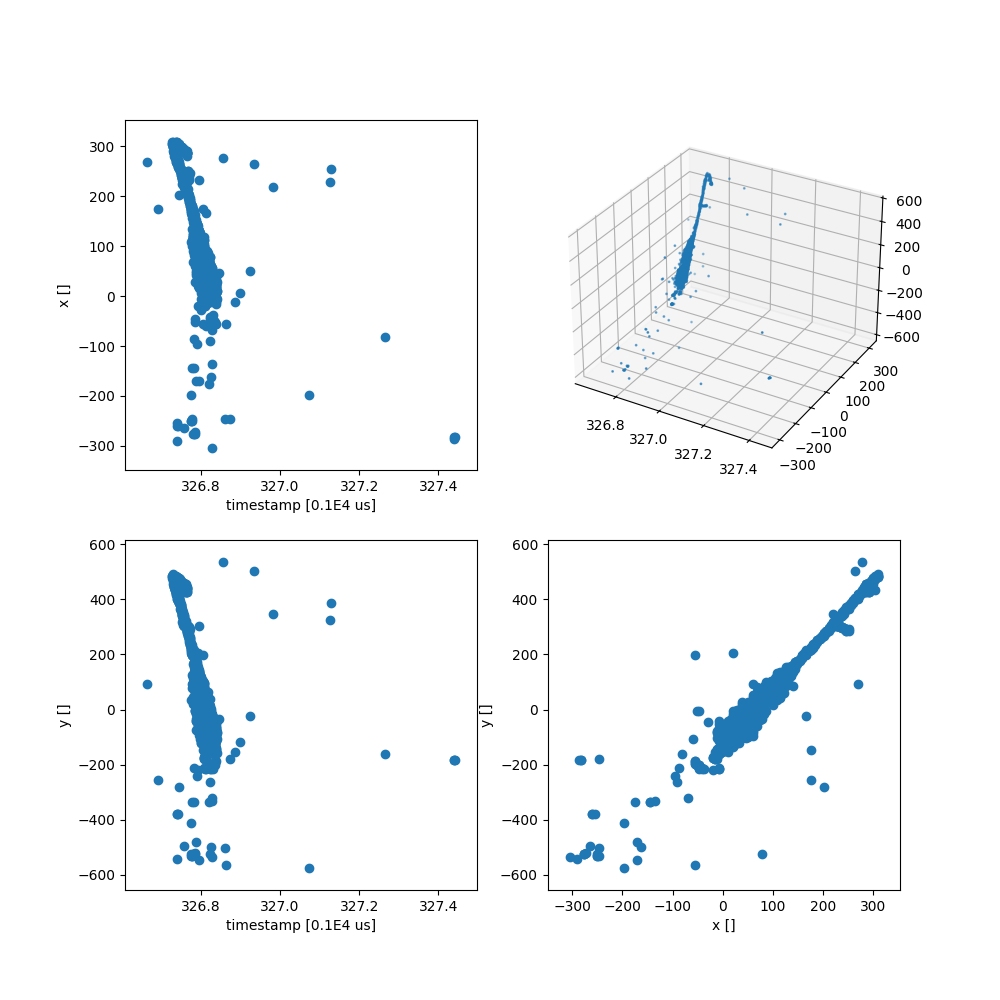

Output()

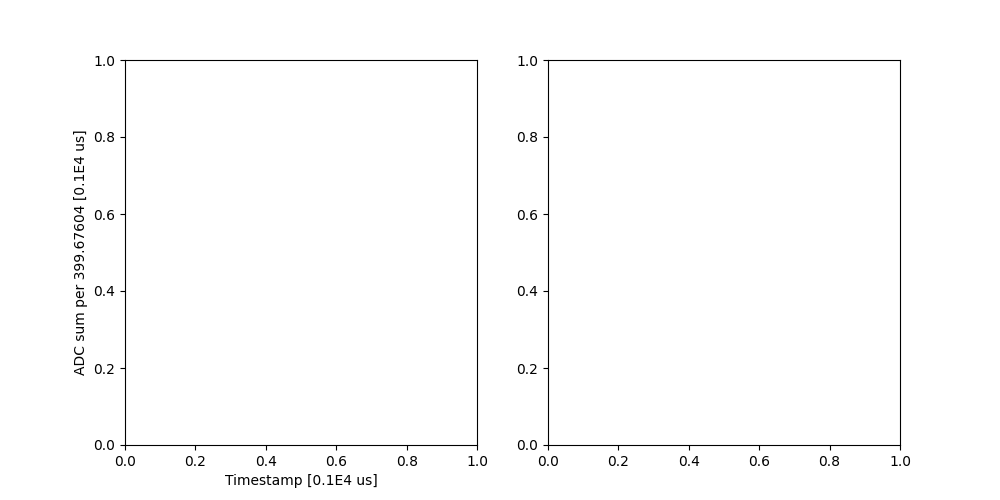

Output()

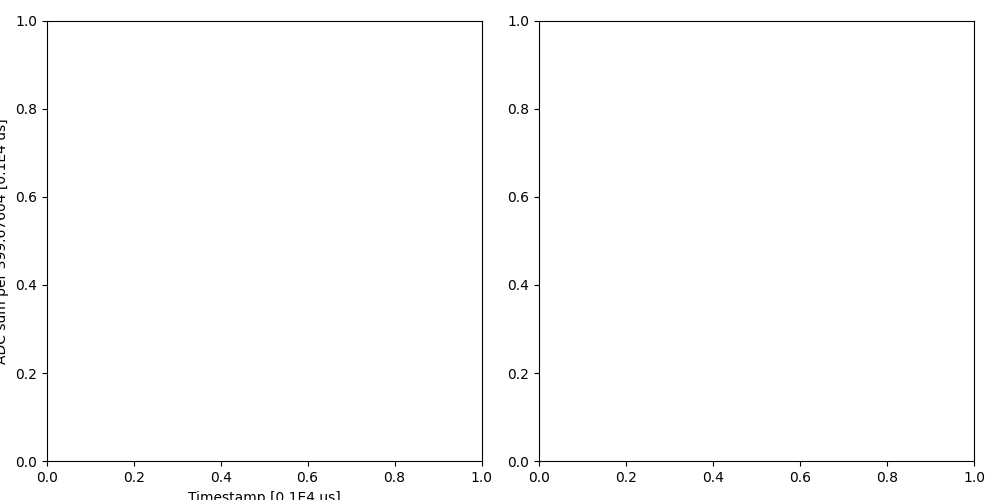

In [14]:
interactive_plot_adc(2, 4, 500)

In [197]:
def plot_picked_region(sync_group, counter, threshold):
    helper = geohelper()
    mg = message_groups[sync_group]
    data_mask=((mg['packet_type']==0)&(mg['valid_parity']==1)&(mg['timestamp']<1e7)) # filter on data packets with valid parity with sync-consistent timestamp 
    data_packets=mg[data_mask]
    print(len(data_packets),' data packets between syncs')

    # histogram the timestamp packet field
    # roughly 200 microseconds binning assuming ticks up to value 1e7 in datastream between syncs
    counts, xbins = np.histogram(data_packets['timestamp'], bins=500)
    bin_width=xbins[1]-xbins[0]

    physics_bins=[] # save to list bin index for bins exceeding threshold
    for i in range(len(counts)):
        if counts[i]>threshold: physics_bins.append(i)

    print(len(physics_bins),' candidate events')

    if len(physics_bins)==1: return # due to correlated-sync noise, we will always have significant pickup near 0 timestamp


    event_mask = (data_packets['timestamp']>=physics_bins[counter]*bin_width)&(data_packets['timestamp']<physics_bins[counter]*bin_width+bin_width) # filter packets on histgrammed bin of interest
    hits = data_packets[event_mask]
    io_channel = hits['io_channel']
    tile_id = np.array([helper.io_channel_to_tile(ioc) for ioc in io_channel])
    chip_id = hits['chip_id']
    channel_id = hits['channel_id']
    timestamp = hits['timestamp']/1e4 # ms
    dataword = hits['dataword'] # ADC value
    # correlate hardware ID to geometry information to find (x,y) position of hits
    xys = np.fromiter((helper.find_xy(tile, chip, channel) for tile, chip, channel in zip(tile_id, chip_id, channel_id)),
                      dtype=np.dtype((np.float64, 2)))
    x = xys[:,0]
    y = xys[:,1]

    print(len(dataword),' hits in event')

    tmin0 = physics_bins[counter]*bin_width / 1E4  #ms
    tmax0 = (physics_bins[counter]*bin_width+bin_width) / 1E4  # ms

    print(picked_points)
    mask = (timestamp > tmin0) & (timestamp < tmax0) & \
            (timestamp > min(picked_points[0][0], picked_points[1][0])) & \
            (timestamp < max(picked_points[0][0], picked_points[1][0])) & \
            (x > min(picked_points[0][1], picked_points[1][1])) & \
            (x < max(picked_points[0][1], picked_points[1][1])) & \
            (y > min(picked_points[0][2], picked_points[1][2])) & \
            (y < max(picked_points[0][2], picked_points[1][2])) & \
            (dataword > 0)
    unique_tile_ids = np.unique(tile_id[mask])
    readout_dict = []
    for unique_tile_id in unique_tile_ids:
        print('checking tile id', unique_tile_id)
        tile_id_mask = tile_id == unique_tile_id
        unique_chip_ids = np.unique(chip_id[tile_id_mask & mask])
        for unique_chip_id in unique_chip_ids:
            print('\tchecking chip id', unique_chip_id)
            chip_id_mask = chip_id == unique_chip_id
            unique_channel_ids = np.unique(channel_id[chip_id_mask & tile_id_mask & mask])

            images = []
            
            for unique_channel_id in unique_channel_ids:
                print('\t\tchecking channel id', unique_channel_id)
                channel_mask = channel_id == unique_channel_id
                idmask = channel_mask & chip_id_mask & tile_id_mask & mask
                
                print('\t\t\ttimestamp', timestamp[idmask])
                
                print('\t\t\tn ADC count', dataword[idmask])
                dt = timestamp[idmask] - timestamp[idmask][-1]

                print('\t\t\ttimestamp diff', dt)
                locxy = helper.find_xy(unique_tile_id, unique_chip_id, unique_channel_id)

                # -0.014099999999984902
                # 75
                # 122
                fig, ax = plt.subplots()
                ax.bar(dt*1E3, dataword[idmask], width=-0.0015*1E3, align='edge')
                ax.set_xlim(-0.016*1E3, 0.002*1E3)
                ax.set_ylim(0, 150)
                ax.set_xlabel('dt w.r.t last [us]')
                ax.set_ylabel('ADC value')
                ax.text(-0.014*1E3, 140, 'tile:chip:channel={}:{}:{}'.format(unique_tile_id, unique_chip_id, unique_channel_id))
                ax.text(-0.014*1E3, 130, '(x, y) = ({:3.1f}, {:3.1f}) [mm]'.format(locxy[0], locxy[1]))
                filename = 'adcs/adc_{}_{}_{}.png'.format(unique_tile_id, unique_chip_id, unique_channel_id)
                fig.savefig(filename)
                plt.close(fig)

                images.append(imageio.v3.imread(filename))

                readout_dict.append({
                    'tile_id' : unique_tile_id,
                    'chip_id' : unique_chip_id,
                    'channel_id' : unique_channel_id,
                    'dt' : dt,
                    'adc' : dataword[idmask],
                    'ts' : timestamp[idmask],
                    'n' : len(dataword[idmask]),
                    'adcsum' : np.sum(dataword[idmask]),
                    'x' : locxy[0],
                    'y' : locxy[1]
                })
            imageio.mimsave('adcs/adc_{}_{}.gif'.format(unique_tile_id, unique_chip_id), images, fps=1)
    return ak.from_iter(readout_dict)

In [198]:
plt.ioff()
readout = plot_picked_region(16, 13, 500)

27470  data packets between syncs
14  candidate events
657  hits in event
[[9.54149258e+02 3.10983954e+02 5.09305645e+02]
 [9.54201161e+02 4.98109839e-01 2.09113288e+02]]
checking tile id 2
	checking chip id 51
		checking channel id 41
			timestamp [954.1529]
			n ADC count [88]
			timestamp diff [0.]
	checking chip id 52
		checking channel id 19
			timestamp [954.151]
			n ADC count [111]
			timestamp diff [0.]
		checking channel id 20
			timestamp [954.1493]
			n ADC count [121]
			timestamp diff [0.]
		checking channel id 21
			timestamp [954.1502]
			n ADC count [86]
			timestamp diff [0.]
		checking channel id 26
			timestamp [954.1515]
			n ADC count [109]
			timestamp diff [0.]
		checking channel id 30
			timestamp [954.151]
			n ADC count [98]
			timestamp diff [0.]
	checking chip id 62
		checking channel id 1
			timestamp [954.1494]
			n ADC count [81]
			timestamp diff [0.]
		checking channel id 44
			timestamp [954.1495]
			n ADC count [81]
			timestamp diff [0.]
		checking 

[282, 277, 277, 273, 273, 268, 268, ..., 20, 24.4, 20, 11.1, 6.65, 11.1, 15.5] 
 [472, 472, 477, 477, 472, 468, 463, 446, ..., 233, 233, 228, 219, 219, 224, 228]


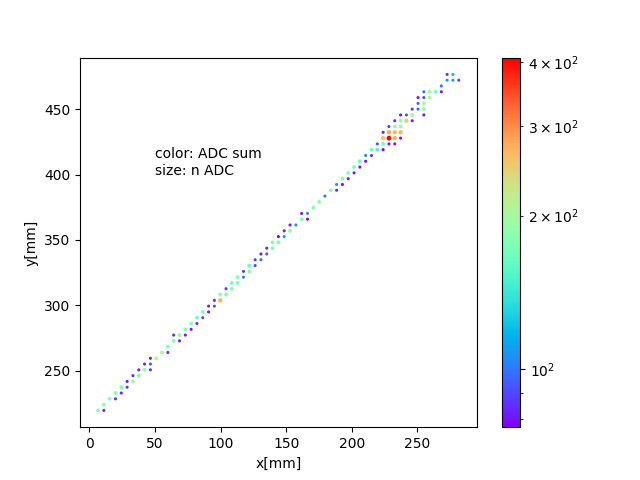

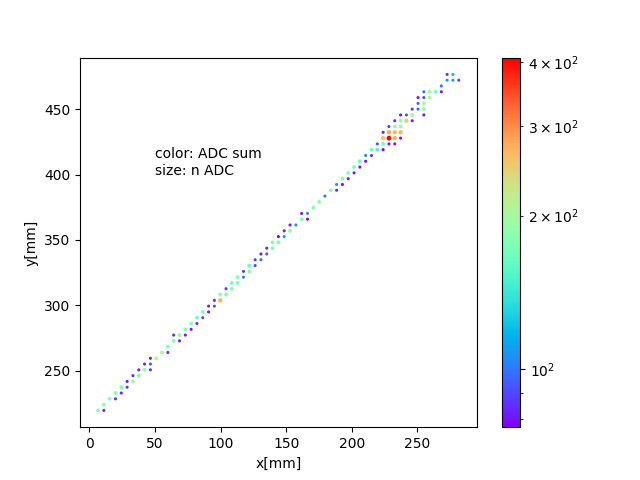

In [193]:
fig, ax = plt.subplots()
sc = ax.scatter(readout['x'], readout['y'], s=readout['n']*1.5, c=readout['adcsum'], norm=matplotlib.colors.LogNorm(), cmap='rainbow') 
ax.set_xlabel('x[mm]')
ax.set_ylabel('y[mm]')
ax.text(50, 400, 'color: ADC sum\nsize: n ADC')
print(readout['x'], '\n', readout['y'])
plt.colorbar(sc)
fig.show()

In [142]:
print(np.min(readout['dt']))
print(np.min(readout['adc']))
print(np.max(readout['adc']))

-0.014099999999984902
75
122


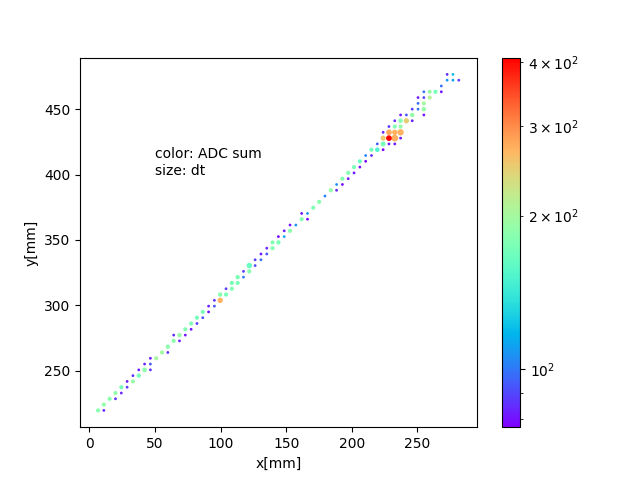

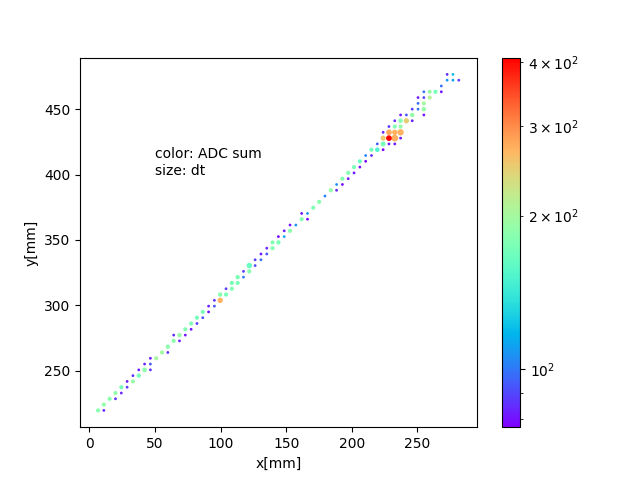

In [183]:
fig, ax = plt.subplots()
sc = ax.scatter(readout['x'], readout['y'], s=1+np.max(np.abs(readout['dt']), axis=1)*1000, c=readout['adcsum'], norm=matplotlib.colors.LogNorm(), cmap='rainbow') 
ax.set_xlabel('x[mm]')
ax.set_ylabel('y[mm]')
ax.text(50, 400, 'color: ADC sum\nsize: dt')
# print(readout['x'], '\n', readout['y'])
plt.colorbar(sc)
fig.show()

In [176]:
1+np.max(np.abs(readout['dt']), axis=1)*1000

<Array [1, 1, 1, 1, 1, 1, 1, ..., 1, 1, 1, 3.8, 3.8, 3.8] type='131 * ?float64'>

In [210]:
hadc_picked = bh.Histogram(bh.axis.Regular(40, 0, 500))
hadc_picked.fill(ak.flatten(readout['adc']))
print(hadc_picked)
hadc_picked

                   ┌─────────────────────────────────────────────────────────┐
[ -inf,     0) 0   │                                                         │
[    0,  12.5) 0   │                                                         │
[ 12.5,    25) 0   │                                                         │
[   25,  37.5) 0   │                                                         │
[ 37.5,    50) 0   │                                                         │
[   50,  62.5) 0   │                                                         │
[ 62.5,    75) 0   │                                                         │
[   75,  87.5) 103 │████████████████████████████████████████████████████████ │
[ 87.5,   100) 67  │████████████████████████████████████▍                    │
[  100, 112.5) 23  │████████████▌                                            │
[112.5,   125) 4   │██▏                                                      │
[  125, 137.5) 0   │                                

Histogram(Regular(40, 0, 500), storage=Double()) # Sum: 197.0

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x3097f4cb0>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)]

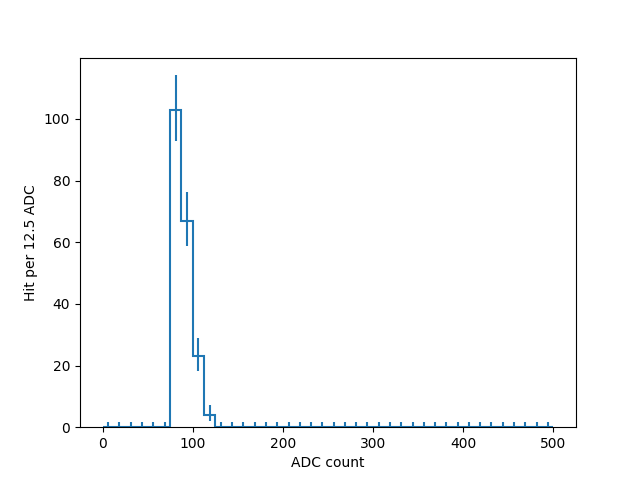

In [211]:
fig, ax = plt.subplots()
ax.set_xlabel('ADC count')
ax.set_ylabel('Hit per {} ADC'.format(hadc_picked.axes.edges[0][1]-hadc_picked.axes.edges[0][0]))
mplhep.histplot(hadc_picked, ax=ax)

In [212]:
picked_points

array([[9.54149258e+02, 3.10983954e+02, 5.09305645e+02],
       [9.54201161e+02, 4.98109839e-01, 2.09113288e+02]])

In [213]:
(9.54149258e+02-9.54201161e+02)/(3.10983954e+02-4.98109839e-01)

-0.00016716704151256207

In [214]:
(9.54149258e+02-9.54201161e+02)/(5.09305645e+02-2.09113288e+02)

-0.0001728991388009414